In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 5, 9]
linestyles = ['--', '-.', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc =300

ng =7

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 7 /) 

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

klin =5e-25

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

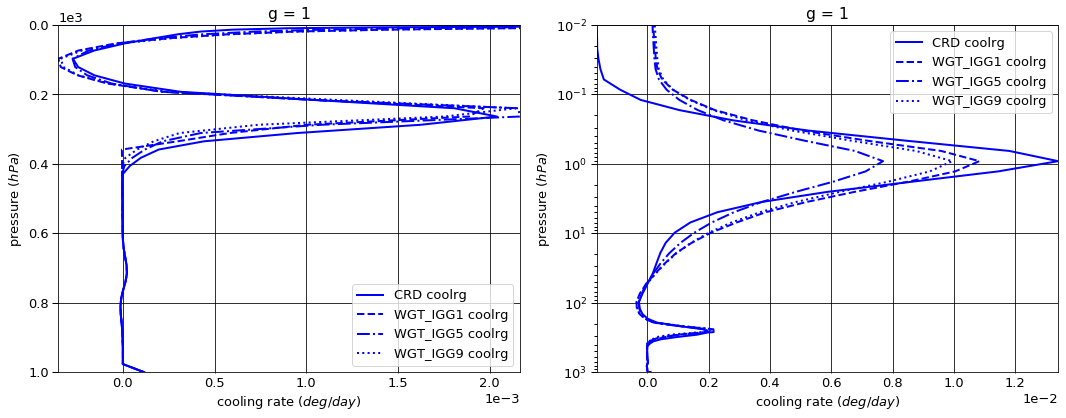

# Figure: cooling rate g-group 2

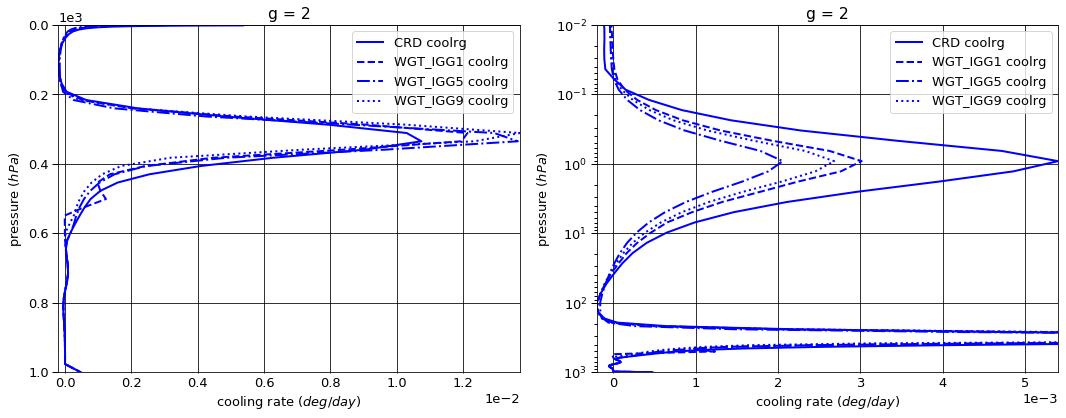

# Figure: cooling rate g-group 3

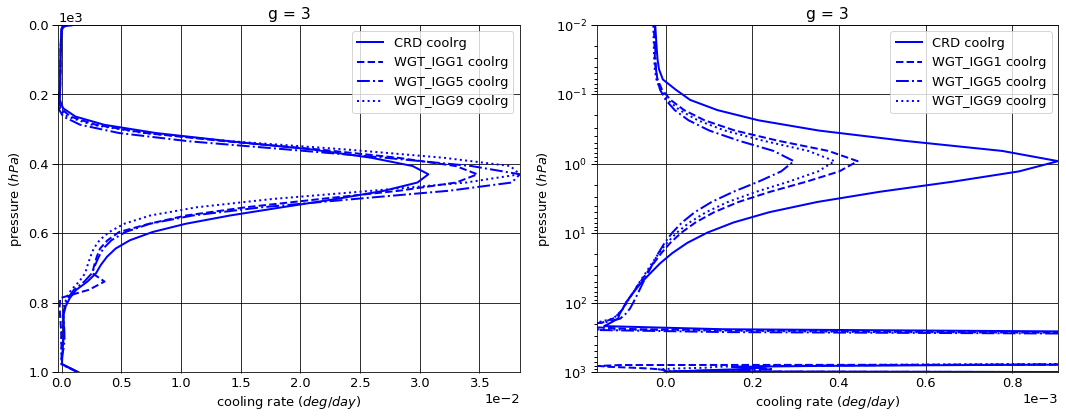

# Figure: cooling rate g-group 4

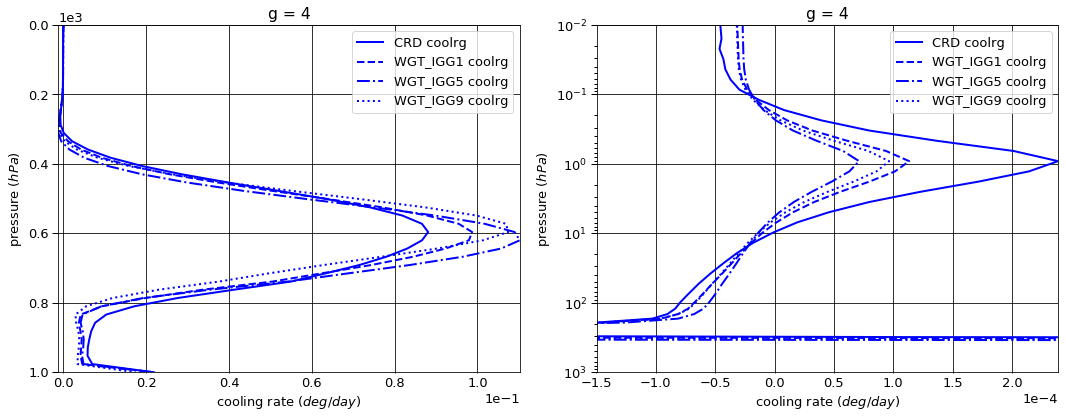

# Figure: cooling rate g-group 5

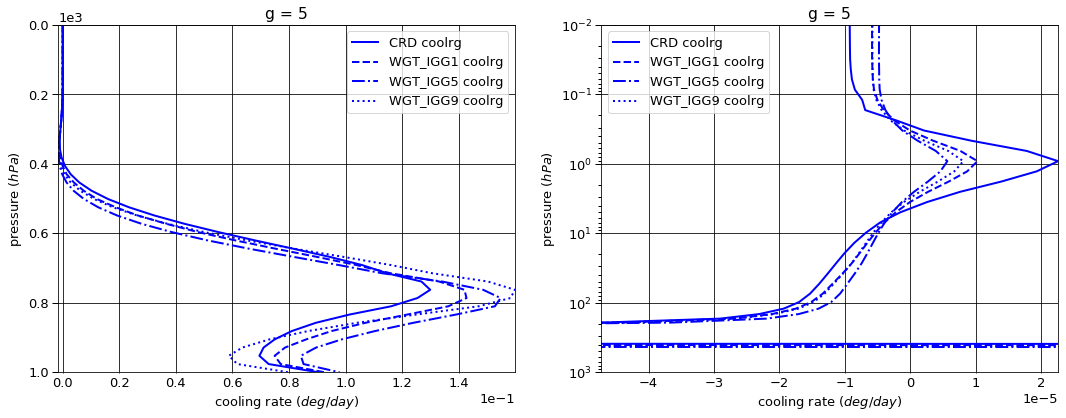

# Figure: cooling rate g-group 6

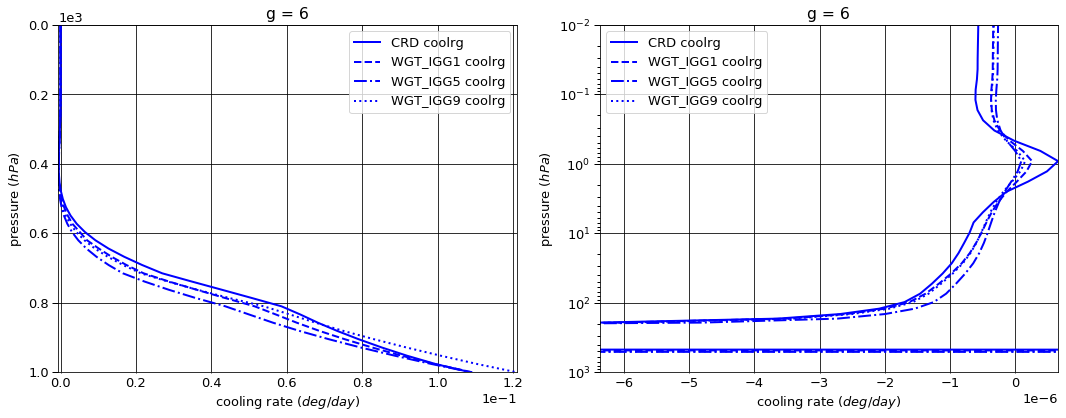

# Figure: cooling rate g-group 7

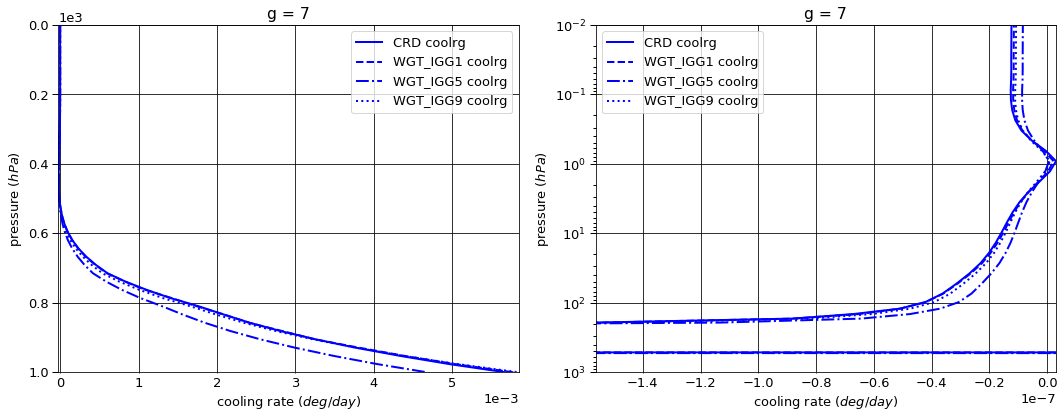

# Figure: cooling rate g-group total

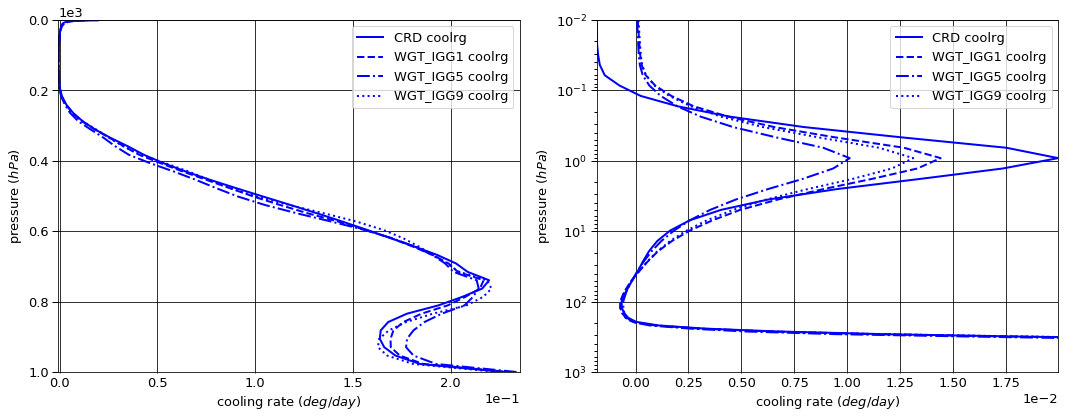

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.028306  0.000000 -0.028306
  1013.0   76    -0.224710  0.224380 -0.000330
2 0.0      1     -0.182853  0.000000 -0.182853
  1013.0   76    -0.926921  0.925579 -0.001343
3 0.0      1     -0.822948  0.000000 -0.822948
  1013.0   76    -2.679657  2.675654 -0.004003
4 0.0      1     -3.292499  0.000000 -3.292499
  1013.0   76    -6.970612  6.902835 -0.067777
5 0.0      1     -5.831315  0.000000 -5.831315
  1013.0   76    -8.541478  7.771016 -0.770461
6 0.0      1     -5.860450  0.000000 -5.860450
  1013.0   76    -6.642266  3.477996 -3.164271
7 0.0      1     -0.954472  0.000000 -0.954472
  1013.0   76    -0.977103  0.124704 -0.852399


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025065  0.000000 -0.025065
  1013.0   76    -0.224710  0.224380 -0.000330
2 0.0      1     -0.175099  0.000000 -0.175099
  1013.0   76    -0.926921  0.925579 -0.001343
3 0.0      1     -0.804077  0.000000 -0.804077
  1013.0   76    -2.679657  2.675801 -0.003856
4 0.0      1     -3.268100  0.000000 -3.268100
  1013.0   76    -6.970612  6.911024 -0.059588
5 0.0      1     -5.874483  0.000000 -5.874483
  1013.0   76    -8.541478  7.964012 -0.577466
6 0.0      1     -5.952039  0.000000 -5.952039
  1013.0   76    -6.642266  3.181227 -3.461039
7 0.0      1     -0.954494  0.000000 -0.954494
  1013.0   76    -0.977103  0.125267 -0.851837


WGT_IGG5


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025039  0.000000 -0.025039
  1013.0   76    -0.224710  0.224380 -0.000330
2 0.0      1     -0.180424  0.000000 -0.180424
  1013.0   76    -0.926921  0.925579 -0.001343
3 0.0      1     -0.827332  0.000000 -0.827332
  1013.0   76    -2.679657  2.675801 -0.003856
4 0.0      1     -3.369552  0.000000 -3.369552
  1013.0   76    -6.970612  6.911737 -0.058875
5 0.0      1     -6.032347  0.000000 -6.032347
  1013.0   76    -8.541478  7.945784 -0.595694
6 0.0      1     -6.067636  0.000000 -6.067636
  1013.0   76    -6.642266  2.830167 -3.812099
7 0.0      1     -0.960232  0.000000 -0.960232
  1013.0   76    -0.977103  0.096330 -0.880773


WGT_IGG9


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023911  0.000000 -0.023911
  1013.0   76    -0.224710  0.224380 -0.000330
2 0.0      1     -0.171281  0.000000 -0.171281
  1013.0   76    -0.926921  0.925579 -0.001343
3 0.0      1     -0.784938  0.000000 -0.784938
  1013.0   76    -2.679657  2.675801 -0.003856
4 0.0      1     -3.191629  0.000000 -3.191629
  1013.0   76    -6.970612  6.924940 -0.045672
5 0.0      1     -5.771808  0.000000 -5.771808
  1013.0   76    -8.541478  8.131884 -0.409594
6 0.0      1     -5.937405  0.000000 -5.937405
  1013.0   76    -6.642266  3.368023 -3.274243
7 0.0      1     -0.955618  0.000000 -0.955618
  1013.0   76    -0.977103  0.121918 -0.855185


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      3.241493e-03  0.000000  3.241493e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      7.753770e-03  0.000000  7.753770e-03
  1013.0   76     0.000000e+00  0.000000  2.168404e-19
3 0.0      1      1.887106e-02  0.000000  1.887106e-02
  1013.0   76     0.000000e+00  0.000147  1.468289e-04
4 0.0      1      2.439860e-02  0.000000  2.439860e-02
  1013.0   76     0.000000e+00  0.008189  8.189167e-03
5 0.0      1     -4.316810e-02  0.000000 -4.316810e-02
  1013.0   76     0.000000e+00  0.192996  1.929957e-01
6 0.0      1     -9.158810e-02  0.000000 -9.158810e-02
  1013.0   76     0.000000e+00 -0.296769 -2.967686e-01
7 0.0      1     -2.227000e-05  0.000000 -2.227000e-05
  1013.0   76     1.110223e-16  0.000562  5.623300e-04


WGT_IGG5 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      3.266698e-03  0.000000  3.266698e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      2.428640e-03  0.000000  2.428640e-03
  1013.0   76     0.000000e+00  0.000000  2.168404e-19
3 0.0      1     -4.383960e-03  0.000000 -4.383960e-03
  1013.0   76     0.000000e+00  0.000147  1.468288e-04
4 0.0      1     -7.705340e-02  0.000000 -7.705340e-02
  1013.0   76     0.000000e+00  0.008902  8.902096e-03
5 0.0      1     -2.010327e-01  0.000000 -2.010327e-01
  1013.0   76     0.000000e+00  0.174768  1.747675e-01
6 0.0      1     -2.071851e-01  0.000000 -2.071851e-01
  1013.0   76     0.000000e+00 -0.647829 -6.478286e-01
7 0.0      1     -5.760220e-03  0.000000 -5.760220e-03
  1013.0   76     1.110223e-16 -0.028374 -2.837378e-02


WGT_IGG9 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      4.395374e-03  0.000000  4.395374e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      1.157224e-02  0.000000  1.157224e-02
  1013.0   76     0.000000e+00  0.000000  2.168404e-19
3 0.0      1      3.801003e-02  0.000000  3.801003e-02
  1013.0   76     0.000000e+00  0.000147  1.468289e-04
4 0.0      1      1.008692e-01  0.000000  1.008692e-01
  1013.0   76     0.000000e+00  0.022105  2.210510e-02
5 0.0      1      5.950650e-02  0.000000  5.950650e-02
  1013.0   76     0.000000e+00  0.360868  3.608676e-01
6 0.0      1     -7.695460e-02  0.000000 -7.695460e-02
  1013.0   76     0.000000e+00 -0.109973 -1.099728e-01
7 0.0      1     -1.145740e-03  0.000000 -1.145740e-03
  1013.0   76     1.110223e-16 -0.002786 -2.786130e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.906646e-03
  1001.112500 75     1.169445e-04
2 0.000312    1     -2.017254e-04
  1001.112500 75     4.758441e-04
3 0.000312    1     -9.543288e-05
  1001.112500 75     1.433898e-03
4 0.000312    1     -5.053449e-05
  1001.112500 75     2.186141e-02
5 0.000312    1     -9.245280e-06
  1001.112500 75     9.048547e-02
6 0.000312    1     -5.368484e-07
  1001.112500 75     1.087581e-01
7 0.000312    1     -1.217777e-08
  1001.112500 75     5.677339e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.983651e-05
  1001.112500 75     1.169445e-04
2 0.000312    1     -6.171040e-05
  1001.112500 75     4.758441e-04
3 0.000312    1     -3.088157e-05
  1001.112500 75     1.366815e-03
4 0.000312    1     -3.365071e-05
  1001.112500 75     2.183292e-02
5 0.000312    1     -5.798496e-06
  1001.112500 75     9.262062e-02
6 0.000312    1     -3.179999e-07
  1001.112500 75     1.091928e-01
7 0.000312    1     -1.135071e-08
  1001.112500 75     5.776936e-03


WGT_IGG5


coolrg
g pressure    layer              
1 0.000312    1      4.699549e-05
  1001.112500 75     1.169445e-04
2 0.000312    1     -6.672882e-05
  1001.112500 75     4.758441e-04
3 0.000312    1     -2.690581e-05
  1001.112500 75     1.366815e-03
4 0.000312    1     -2.827188e-05
  1001.112500 75     2.187055e-02
5 0.000312    1     -4.696076e-06
  1001.112500 75     9.784782e-02
6 0.000312    1     -2.463232e-07
  1001.112500 75     1.090091e-01
7 0.000312    1     -8.291629e-09
  1001.112500 75     4.677135e-03


WGT_IGG9


coolrg
g pressure    layer              
1 0.000312    1      8.539126e-05
  1001.112500 75     1.169445e-04
2 0.000312    1     -7.294416e-05
  1001.112500 75     4.758441e-04
3 0.000312    1     -3.150774e-05
  1001.112500 75     1.366815e-03
4 0.000312    1     -3.369242e-05
  1001.112500 75     1.741238e-02
5 0.000312    1     -5.710128e-06
  1001.112500 75     7.975329e-02
6 0.000312    1     -3.085495e-07
  1001.112500 75     1.209928e-01
7 0.000312    1     -1.060470e-08
  1001.112500 75     5.847024e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.926483e-03
  1001.112500 75    -1.355253e-20
2 0.000312    1      1.400150e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      6.455131e-05
  1001.112500 75    -6.708330e-05
4 0.000312    1      1.688378e-05
  1001.112500 75    -2.849400e-05
5 0.000312    1      3.446784e-06
  1001.112500 75     2.135155e-03
6 0.000312    1      2.188486e-07
  1001.112500 75     4.346300e-04
7 0.000312    1      8.270620e-10
  1001.112500 75     9.959700e-05


WGT_IGG5 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.953642e-03
  1001.112500 75    -1.355253e-20
2 0.000312    1      1.349966e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      6.852707e-05
  1001.112500 75    -6.708320e-05
4 0.000312    1      2.226261e-05
  1001.112500 75     9.140000e-06
5 0.000312    1      4.549204e-06
  1001.112500 75     7.362349e-03
6 0.000312    1      2.905252e-07
  1001.112500 75     2.509400e-04
7 0.000312    1      3.886138e-09
  1001.112500 75    -1.000204e-03


WGT_IGG9 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.992038e-03
  1001.112500 75    -1.355253e-20
2 0.000312    1      1.287813e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      6.392514e-05
  1001.112500 75    -6.708330e-05
4 0.000312    1      1.684206e-05
  1001.112500 75    -4.449027e-03
5 0.000312    1      3.535152e-06
  1001.112500 75    -1.073218e-02
6 0.000312    1      2.282990e-07
  1001.112500 75     1.223470e-02
7 0.000312    1      1.573068e-09
  1001.112500 75     1.696855e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.972842,0.000000,-16.972842
1013.0,76,-26.962746,22.102163,-4.860583



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.053356,0.000000,-17.053356
1013.0,76,-26.962746,22.007289,-4.955457



WGT_IGG5


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.462562,0.000000,-17.462562
1013.0,76,-26.962746,21.609778,-5.352969



WGT_IGG9


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.836589,0.000000,-16.836589
1013.0,76,-26.962746,22.372524,-4.590222



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.080514,0.000000,-0.080514
1013.0,76,0.000000,-0.094875,-0.094875



WGT_IGG5 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.48972,0.000000,-0.489720
1013.0,76,0.00000,-0.492386,-0.492386



WGT_IGG9 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.136253,0.00000,0.136253
1013.0,76,0.000000,0.27036,0.270361


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002264
1001.112500,75,0.228809



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000113
1001.112500,75,0.231383



WGT_IGG5


,,coolrg
pressure,layer,
0.000312,1,-0.000080
1001.112500,75,0.235364



WGT_IGG9


,,coolrg
pressure,layer,
0.000312,1,-0.000059
1001.112500,75,0.225965



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002152
1001.112500,75,0.002574



WGT_IGG5 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002184
1001.112500,75,0.006555



WGT_IGG9 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002205
1001.112500,75,-0.002844


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.009818,0.007805
2,0.038636,0.032818
3,0.109424,0.095711
4,0.277121,0.251508
5,0.310485,0.318695
6,0.223394,0.255171
7,0.031121,0.038291


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.448496e-20
2,1.856093e-21
3,2.378385e-22
4,3.047647e-23
5,3.905235e-24
6,5.004142e-25
7,1.858499e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.448496e-20,NaN,0.009818,0.007805,0.009818,0.007805,600.0
2,1.856093e-21,0.128139,0.038636,0.032818,0.048455,0.040623,600.0
3,2.378385e-22,0.128139,0.109424,0.095711,0.157879,0.136334,600.0
4,3.047647e-23,0.128139,0.277121,0.251508,0.435000,0.387842,600.0
5,3.905235e-24,0.128139,0.310485,0.318695,0.745485,0.706538,600.0
6,5.004142e-25,0.128139,0.223394,0.255171,0.968879,0.961709,600.0
7,1.858499e-25,0.371392,0.031121,0.038291,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.515865e-20  1.116263e-21  22.538271  9.090256e-07
      2 0.000312     1.597169e-21  7.201462e-23  22.178399  5.774827e-08
      3 0.000312     8.014693e-23  6.295903e-24  12.730013  2.990638e-09
      4 0.000312     1.682922e-23  9.083819e-25  18.526591  6.136628e-10
      5 0.000312     1.396747e-24  9.693235e-26  14.409500  5.167639e-11
      6 0.000312     6.603964e-26  8.466793e-27   7.799842  2.577678e-12
      7 0.000312     8.523858e-27  2.030552e-27   4.197804  5.448656e-13
2     1 0.000750     2.529483e-20  1.118016e-21  22.624742  3.680655e-07
      2 0.000750     1.606168e-21  7.220227e-23  22.245391  2.338825e-08
      3 0.000750     8.059219e-23  6.312069e-24  12.767951  1.211019e-09
      4 0.000750     1.686490e-23  9.106797e-25  18.519021  2.477044e-10
      5 0.000750     1.402946e-24  9.725900e-26  14.424848  2.090550e-11
      6 0.000750     6.643442e-26  8.503220e-27   7.812855  1.044263e-12
      7 0.000750     8.553438e-27  2.036635e-27   4.199789  2.202235e-13
3     1 0.001052     2.557240e-20  1.121375e-21  22.804509  5.216598e-07
      2 0.001052     1.624551e-21  7.256497e-23  22.387541  3.316569e-08
      3 0.001052     8.150323e-23  6.343728e-24  12.847846  1.716739e-09
      4 0.001052     1.693783e-23  9.151544e-25  18.508163  3.488897e-10
      5 0.001052     1.415593e-24  9.790370e-26  14.459038  2.957733e-11
      6 0.001052     6.724365e-26  8.575696e-27   7.841189  1.481691e-12
      7 0.001052     8.613970e-27  2.048802e-27   4.204394  3.110151e-13
4     1 0.001476     2.585619e-20  1.124816e-21  22.987050  7.397073e-07
      2 0.001476     1.643391e-21  7.293421e-23  22.532508  4.705450e-08
      3 0.001476     8.243980e-23  6.376095e-24  12.929513  2.434963e-09
      4 0.001476     1.701264e-23  9.197624e-25  18.496772  4.916319e-10
      5 0.001476     1.428538e-24  9.856613e-26  14.493192  4.186685e-11
      6 0.001476     6.807783e-26  8.650079e-27   7.870197  2.103561e-12
      7 0.001476     8.676445e-27  2.061346e-27   4.209117  4.394725e-13
5     1 0.002070     2.614244e-20  1.128313e-21  23.169499  1.048645e-06
      2 0.002070     1.662436e-21  7.330626e-23  22.677952  6.674468e-08
      3 0.002070     8.338970e-23  6.408833e-24  13.011681  3.453033e-09
      4 0.002070     1.708835e-23  9.244611e-25  18.484662  6.926486e-10
      5 0.002070     1.441609e-24  9.923945e-26  14.526573  5.925042e-11
      6 0.002070     6.892624e-26  8.725554e-27   7.899354  2.985953e-12
      7 0.002070     8.740084e-27  2.074135e-27   4.213846  6.209015e-13
6     1 0.002904     2.643106e-20  1.131892e-21  23.351211  1.486735e-06
      2 0.002904     1.681683e-21  7.368307e-23  22.823188  9.468377e-08
      3 0.002904     8.435288e-23  6.442082e-24  13.094041  4.897446e-09
      4 0.002904     1.716497e-23  9.292737e-25  18.471379  9.759966e-10
      5 0.002904     1.454805e-24  9.992611e-26  14.558812  8.386164e-11
      6 0.002904     6.978899e-26  8.802330e-27   7.928468  4.239186e-12
      7 0.002904     8.804920e-27  2.087208e-27   4.218517  8.773980e-13
7     1 0.004074     2.672204e-20  1.135592e-21  23.531364  2.107850e-06
      2 0.004074     1.701129e-21  7.406761e-23  22.967253  1.343204e-07
      3 0.004074     8.532949e-23  6.476051e-24  13.176161  6.946473e-09
      4 0.004074     1.724249e-23  9.342352e-25  18.456265  1.375344e-09
      5 0.004074     1.468128e-24  1.006298e-25  14.589385  1.187002e-10
      6 0.004074     7.066633e-26  8.880726e-27   7.957269  6.018934e-12
      7 0.004074     8.871005e-27  2.100619e-27   4.223043  1.239994e-12
8     1 0.005714     2.701559e-20  1.139470e-21  23.708910  2.988206e-06
      2 0.005714     1.720788e-21  7.446437e-23  23.108881  1.905372e-07
      3 0.005714     8.632038e-23  6.511066e-24  13.257488  9.852563e-09
      4 0.005714     1.732099e-23  9.393982e-25  18.438391  1.938047e-09
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
